<a href="https://colab.research.google.com/github/PedroGurg/Dimensionalidade-Spike-sorting/blob/main/Dimensionalidade_spike_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install klusta --pre --upgrade

     |████████████████████████████████| 87 kB 3.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from klusta.kwik import KwikModel
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
#/content/drive/MyDrive/Dimensionalidade/g03.kwik

data = "/content/drive/MyDrive/Dimensionalidade/g03.kwik"

In [ ]:
kmodel=KwikModel(data)

In [ ]:
kmodel.cluster_groups

In [ ]:
class read_kwik:
  def __init__(self,kmodel):
    self.kmodel = kmodel # instancia que copia o kmodel
    self.G = kmodel.cluster_groups#pega os grupos de clusters do arquiivo
    self.t,self.clu = kmodel.spike_times,kmodel.spike_clusters #pega os tempos e os neuronios do arquivo ps: poss:ui constancia com o tempo > ambos andam juntos 
    self.non_noise_group = self.get_noise_clusters()
    self.mua = self.get_mua_clu()# sua instancia é o retorno da função que pega do arquivo os neuronios com resposta sua e mua
    self.sua = self.get_sua_clu()

  def get_noise_clusters(self):
    # retorna uma lista com os closters que não são noise
    noise_clusters = [] #lista que será alocado os não noise
    for c in self.G.keys(): 
      if self.G[c] != 'noise': # todos os valores que não são noise será alocado na lista
        noise_clusters.append(c)
    # transformando em uma instancia a lista criada com os não noise]
    return noise_clusters

  def get_spike_times(self):
    # alocando o valor do retorno da função noise em uma variavel
    mask = np.isin(self.clu,self.non_noise_group)# cria um vetor de true/false entre os dois parametros, o parametro de referencia busca no secundário seus valores presentes nele, caso o de referencia possua, marca true, caso não, marca falso
    clu = self.clu[mask]# seleciona no parametro self.clu apenas os que possuem true
    t = self.t[mask]# seleciojna no parametro self.t apenas os que possuem true
    return (clu,t)
    
  def get_clu (self, clu_group): # ainda n entendi quem é esse clu_group
    if not(clu_group in ['SUA', 'MUA']):
      return (None)
    if (clu_group=='SUA'):
      return (self.get_sua_clu())
    if (clu_group=='MUA'):
        return (self.get_mua_clu())

  def get_sua_clu(self):
    sua_group = []
    for c in self.G.keys():
      if self.G[c] != 'mua' and self.G[c] != 'noise':
        sua_group.append(c)
    return sua_group #retorna uma lista com todos os registros SUA

  def get_mua_clu(self): 
    mua_group = []
    for c in self.G.keys():
     if self.G[c] == 'mua':
        mua_group.append(c)
    return mua_group # retorna uma lista com todos os registros MUA

  def get_spikes_clu(self,clu_label,a = 0,b = None): # pega a atividade do neuronio especificio em um intervalo de tempo selecionado
     if (b is None):
      b = self.t[-1]
     spikes=self.t[self.clu==clu_label] # pega em kmodel.t o tempo de atividade do clu escolhido
     spikes = spikes[ (spikes>=a) & (spikes<=b)] # delimita o intervalo de tempo desejado
     return (spikes)

class FireRate:
  def __init__(self,time,clu,bin_size =0.05,a = 0,b = None):
    self.bin_size = bin_size
    if (b is None):
      b = t[-1]
    bins = np.arange(a,b,self.bin_size)
    ifr,bins = np.histogram(time,bins=bins)
    T = bins[0:-1]
    self.spikes=pd.Series(ifr/bin_size, index=T)



In [ ]:
kwik = read_kwik(kmodel)
SUA_values = kwik.sua

In [ ]:
valeus = pd.Series(index = SUA_values, dtype = int)
SUA_ord = list(valeus.sort_values(ascending = False).index)
SUA_ord

[16, 30, 72, 70, 69, 67, 61, 60, 58, 55, 47, 45, 41, 38, 37, 36, 35, 73]

In [ ]:
figure(figsize=(18, 6), dpi=80)
FR = {}
for c in SUA_ord:
  t = kwik.get_spikes_clu(c)
  clu = np.ones(len(t))
  FR[c] =FireRate(t,clu,bin_size =10,a = 0,b = 4650).spikes
  FR[c].plot()

In [ ]:
IFR=pd.DataFrame(FR)

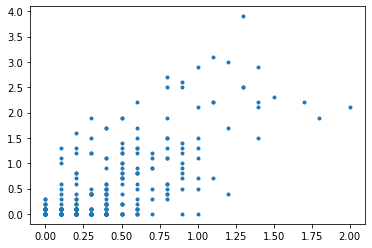

In [ ]:
plt.plot(IFR[38].values,IFR[55].values,'.')
#relação ascendente entre os neuronios

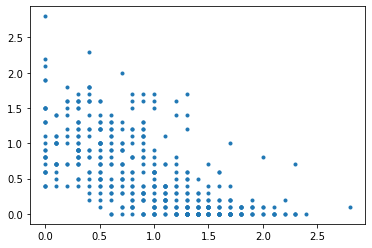

In [ ]:
plt.plot(IFR[37].values,IFR[60].values,'.')
# relação descendente entre os neuronios 

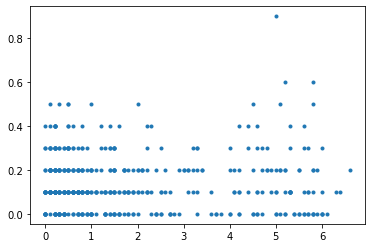

In [ ]:
plt.plot(IFR[69].values,IFR[36].values,'.')
# relação praticamente nula entre os neuronios 

In [ ]:
R=IFR.corr()
R.values[[np.arange(R.shape[0])]*2] = 0
#61/16
#73/67
#36/69

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [ ]:
# indentificando a correlação mais ascendente entre os grupos de neuronios
R.style.highlight_max(color = 'blue')

,16,30,72,70,69,67,61,60,58,55,47,45,41,38,37,36,35,73
16,0.000000,-0.111856,-0.200734,0.133302,-0.202546,0.202344,-0.008430,-0.249560,-0.098745,0.056473,-0.171759,-0.182760,-0.112485,0.078459,0.301211,0.028863,0.044404,0.010512
30,-0.111856,0.000000,0.422314,-0.195455,0.301205,-0.285262,-0.066196,0.426555,0.146772,-0.080251,0.323040,0.465693,0.225501,0.057344,-0.297649,0.176616,-0.046059,0.164404
72,-0.200734,0.422314,0.000000,-0.292952,0.116526,-0.302341,-0.076387,0.447395,-0.249786,-0.110036,0.177597,0.399872,0.463228,-0.071731,-0.315934,0.248307,0.132471,0.024790
70,0.133302,-0.195455,-0.292952,0.000000,-0.379815,0.248122,-0.226523,-0.545679,-0.209142,0.554420,-0.309450,-0.226938,-0.022465,0.450120,0.531544,-0.014415,-0.098979,-0.067147
69,-0.202546,0.301205,0.116526,-0.379815,0.000000,-0.321793,0.189680,0.544724,0.683454,-0.405439,0.620768,0.393313,-0.059206,-0.288590,-0.639595,0.001320,-0.020596,0.176536
67,0.202344,-0.285262,-0.302341,0.248122,-0.321793,0.000000,0.040636,-0.421174,-0.197208,0.097116,-0.414871,-0.109428,-0.076930,0.090182,0.436751,-0.048626,0.063406,0.003625
61,-0.008430,-0.066196,-0.076387,-0.226523,0.189680,0.040636,0.000000,0.180293,0.073650,-0.151697,0.218079,-0.164155,-0.086707,-0.186199,-0.228602,0.018370,-0.052122,0.005971
60,-0.249560,0.426555,0.447395,-0.545679,0.544724,-0.421174,0.180293,0.000000,0.209093,-0.484213,0.455301,0.312172,0.071009,-0.449946,-0.649648,0.100634,0.043545,0.064305
58,-0.098745,0.146772,-0.249786,-0.209142,0.683454,-0.197208,0.073650,0.209093,0.000000,-0.194909,0.487093,0.350371,-0.202683,-0.091829,-0.421469,-0.116008,-0.131159,0.263583
55,0.056473,-0.080251,-0.110036,0.554420,-0.405439,0.097116,-0.151697,-0.484213,-0.194909,0.000000,-0.238044,-0.299014,0.154074,0.747174,0.483428,0.101630,-0.117000,-0.049082


In [ ]:
# indentificando a correlação mais descendente entre os grupos de neuronios
R.style.highlight_min(color ='blue')

,16,30,72,70,69,67,61,60,58,55,47,45,41,38,37,36,35,73
16,0.000000,-0.111856,-0.200734,0.133302,-0.202546,0.202344,-0.008430,-0.249560,-0.098745,0.056473,-0.171759,-0.182760,-0.112485,0.078459,0.301211,0.028863,0.044404,0.010512
30,-0.111856,0.000000,0.422314,-0.195455,0.301205,-0.285262,-0.066196,0.426555,0.146772,-0.080251,0.323040,0.465693,0.225501,0.057344,-0.297649,0.176616,-0.046059,0.164404
72,-0.200734,0.422314,0.000000,-0.292952,0.116526,-0.302341,-0.076387,0.447395,-0.249786,-0.110036,0.177597,0.399872,0.463228,-0.071731,-0.315934,0.248307,0.132471,0.024790
70,0.133302,-0.195455,-0.292952,0.000000,-0.379815,0.248122,-0.226523,-0.545679,-0.209142,0.554420,-0.309450,-0.226938,-0.022465,0.450120,0.531544,-0.014415,-0.098979,-0.067147
69,-0.202546,0.301205,0.116526,-0.379815,0.000000,-0.321793,0.189680,0.544724,0.683454,-0.405439,0.620768,0.393313,-0.059206,-0.288590,-0.639595,0.001320,-0.020596,0.176536
67,0.202344,-0.285262,-0.302341,0.248122,-0.321793,0.000000,0.040636,-0.421174,-0.197208,0.097116,-0.414871,-0.109428,-0.076930,0.090182,0.436751,-0.048626,0.063406,0.003625
61,-0.008430,-0.066196,-0.076387,-0.226523,0.189680,0.040636,0.000000,0.180293,0.073650,-0.151697,0.218079,-0.164155,-0.086707,-0.186199,-0.228602,0.018370,-0.052122,0.005971
60,-0.249560,0.426555,0.447395,-0.545679,0.544724,-0.421174,0.180293,0.000000,0.209093,-0.484213,0.455301,0.312172,0.071009,-0.449946,-0.649648,0.100634,0.043545,0.064305
58,-0.098745,0.146772,-0.249786,-0.209142,0.683454,-0.197208,0.073650,0.209093,0.000000,-0.194909,0.487093,0.350371,-0.202683,-0.091829,-0.421469,-0.116008,-0.131159,0.263583
55,0.056473,-0.080251,-0.110036,0.554420,-0.405439,0.097116,-0.151697,-0.484213,-0.194909,0.000000,-0.238044,-0.299014,0.154074,0.747174,0.483428,0.101630,-0.117000,-0.049082


Text(0.5, 1.0, 'Population activity')

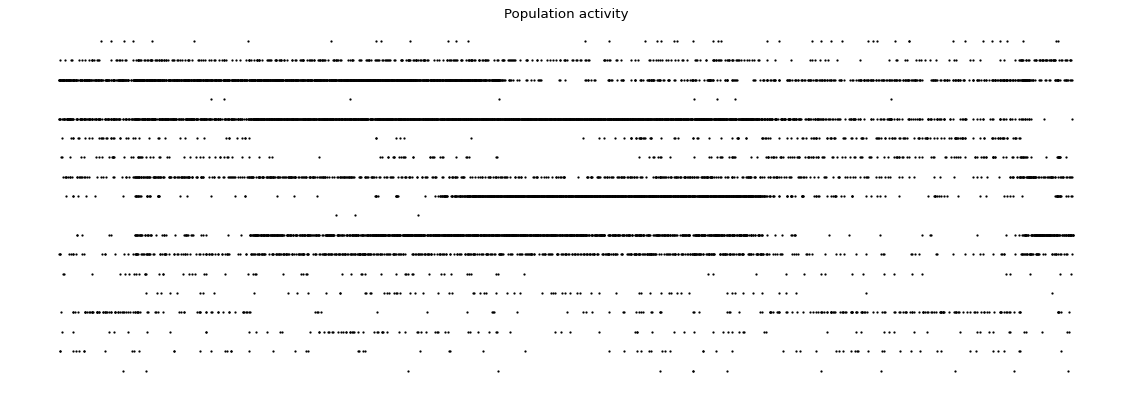

In [ ]:
# raster plot evidenciando a atividade unitária de cada neuronio ao longo do tempo. cada linha representa a atividade de um unico neuronio
def plot_raster_clu (spikes, y_clu, a,b):
  ''' Show raster plot for a given clu in a given
      time interval [a,b].

  '''
  spikes=spikes[(spikes>=a) & (spikes<=b) ]
  nspikes=len(spikes)
  X=spikes
  Y=[y_clu]*nspikes
  plt.plot (X,Y,'.k', ms=2)
y=0
figure(figsize=(18, 6), dpi=80)
for id in SUA_ord:
  spikes = t=kwik.get_spikes_clu(id)
  plot_raster_clu (spikes, y, a=4000,b=4650)
  y-=1
plt.axis('off')
plt.xlabel('Time (s)')
plt.title ('Population activity')